In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from itertools import product
import re # For cleaning functions

#hyperparameters
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30 

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# Data Cleaning Functions
def clean_volume(volume_str):
    if isinstance(volume_str, (int, float)):
        return volume_str
    if not isinstance(volume_str, str):
        return np.nan
    volume_str = volume_str.strip().upper()
    if volume_str == '-' or volume_str == '':
        return np.nan
    multipliers = {'K': 10**3, 'M': 10**6, 'B': 10**9}
    if volume_str[-1] in multipliers:
        return float(volume_str[:-1]) * multipliers[volume_str[-1]]
    return float(volume_str)

def clean_change_pct(change_str):
    if isinstance(change_str, (int, float)):
        return change_str
    if not isinstance(change_str, str):
        return np.nan
    change_str = change_str.strip()
    if change_str == '-' or change_str == '':
        return np.nan
    if change_str.endswith('%'):
        return float(change_str[:-1]) / 100.0
    return float(change_str)

In [2]:
#define model, using RNN
class StockRNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=3):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # Using vanilla RNN
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) # For RNN, out contains all hidden states for all layers and timesteps
                               # _ contains h_n - final hidden state
        return self.fc(out[:, -1, :]) # Use the output of the last time step from the last layer

# This version aligns with how target_indices was used (indices within the features array)
def create_sequences_from_combined_array(all_scaled_data, seq_len, list_of_target_indices):
    Xs, ys = [], []
    all_scaled_data_np = np.array(all_scaled_data) # Ensure NumPy array for consistent indexing
    for i in range(len(all_scaled_data_np) - seq_len):
        Xs.append(all_scaled_data_np[i:(i + seq_len), :]) 
        ys.append(all_scaled_data_np[i + seq_len, list_of_target_indices])
    return np.array(Xs), np.array(ys)

In [3]:
#load data
DJ_df = pd.read_csv("Dow Jones Industrial Average Historical Data 5Y.csv")
ND_df = pd.read_csv("NASDAQ-100 (NDX) Historical Data 5Y.csv")
SP_df = pd.read_csv("S&P500 5Y.csv")

# Rename columns and set index
dfs = {'DJ': DJ_df, 'NDX': ND_df, 'SAP': SP_df}
for prefix, df in dfs.items():
    df['Date'] = pd.to_datetime(df['Date'])
    new_cols = {'Date': 'Date'}
    for col in df.columns:
        if col not in ['Date']:
            new_cols[col] = f"{prefix}_{col.replace(' ', '').replace('/', '')}"
    df.rename(columns=new_cols, inplace=True)
    df.set_index('Date', inplace=True)

# Clean specific Dow Jones columns
if 'DJ_Vol.' in DJ_df.columns:
    DJ_df['DJ_Vol.'] = DJ_df['DJ_Vol.'].apply(clean_volume)
if 'DJ_Change%' in DJ_df.columns:
    DJ_df['DJ_Change%'] = DJ_df['DJ_Change%'].apply(clean_change_pct)
    DJ_df['DJ_Change%_lagged'] = DJ_df['DJ_Change%'].shift(1)

# Merge dataframes
merged_df = DJ_df.join([ND_df, SP_df], how='inner')
merged_df.sort_index(inplace=True)

# Define features and targets
# !!! IMPORTANT: Review and adjust this 'features_for_scaling' list to your actual needs! !!!
features_to_select = [
    'DJ_Open', 'DJ_High', 'DJ_Low', 'DJ_CloseLast', 'DJ_Vol.', 'DJ_Change%_lagged', 
    'NDX_Open', 'NDX_High', 'NDX_Low', 'NDX_CloseLast',
    'SAP_Open', 'SAP_High', 'SAP_Low', 'SAP_CloseLast' 
]
features_present = [f for f in features_to_select if f in merged_df.columns]

target_cols = ["SAP_CloseLast", "NDX_CloseLast", "DJ_CloseLast"]

# Columns for scaling (features + targets, as per original structure implication)
features_for_scaling = list(features_present) 
for tc in target_cols:
    if tc not in features_for_scaling and tc in merged_df.columns:
        features_for_scaling.append(tc) 
features_for_scaling = list(dict.fromkeys(features_for_scaling)) # Keep unique, preserve order

target_indices_in_scaled_data = []
for col in target_cols:
    if col in features_for_scaling:
        target_indices_in_scaled_data.append(features_for_scaling.index(col))
    else:
        raise ValueError(f"Target column {col} not found in columns selected for scaling: {features_for_scaling}")

merged_df_processed = merged_df[features_for_scaling].copy()
merged_df_processed.dropna(inplace=True)

data_to_scale = merged_df_processed.values
dates_processed = merged_df_processed.index

train_idx_bool = (dates_processed.year >= 2019) & (dates_processed.year <= 2023)
test_idx_bool = dates_processed.year == 2024
val_idx_bool = dates_processed.year == 2025

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(data_to_scale[train_idx_bool])
scaled_test_data = scaler.transform(data_to_scale[test_idx_bool])
scaled_val_data = scaler.transform(data_to_scale[val_idx_bool])

X_train, y_train = create_sequences_from_combined_array(scaled_train_data, SEQ_LEN, target_indices_in_scaled_data)
X_test, y_test = create_sequences_from_combined_array(scaled_test_data, SEQ_LEN, target_indices_in_scaled_data)
X_val, y_val = create_sequences_from_combined_array(scaled_val_data, SEQ_LEN, target_indices_in_scaled_data)

dates_train_seq = dates_processed[train_idx_bool][SEQ_LEN:]
dates_test_seq = dates_processed[test_idx_bool][SEQ_LEN:]
dates_val_seq = dates_processed[val_idx_bool][SEQ_LEN:]

Initial RNN Model: Epoch [5/30], Loss: 0.0018
Initial RNN Model: Epoch [10/30], Loss: 0.0010
Initial RNN Model: Epoch [15/30], Loss: 0.0006
Initial RNN Model: Epoch [20/30], Loss: 0.0006
Initial RNN Model: Epoch [25/30], Loss: 0.0003
Initial RNN Model: Epoch [30/30], Loss: 0.0002
Initial RNN Model - Test RMSE for SAP_CloseLast (2024): 242.14
Initial RNN Model - Test RMSE for NDX_CloseLast (2024): 841.00
Initial RNN Model - Test RMSE for DJ_CloseLast (2024): 1337.22


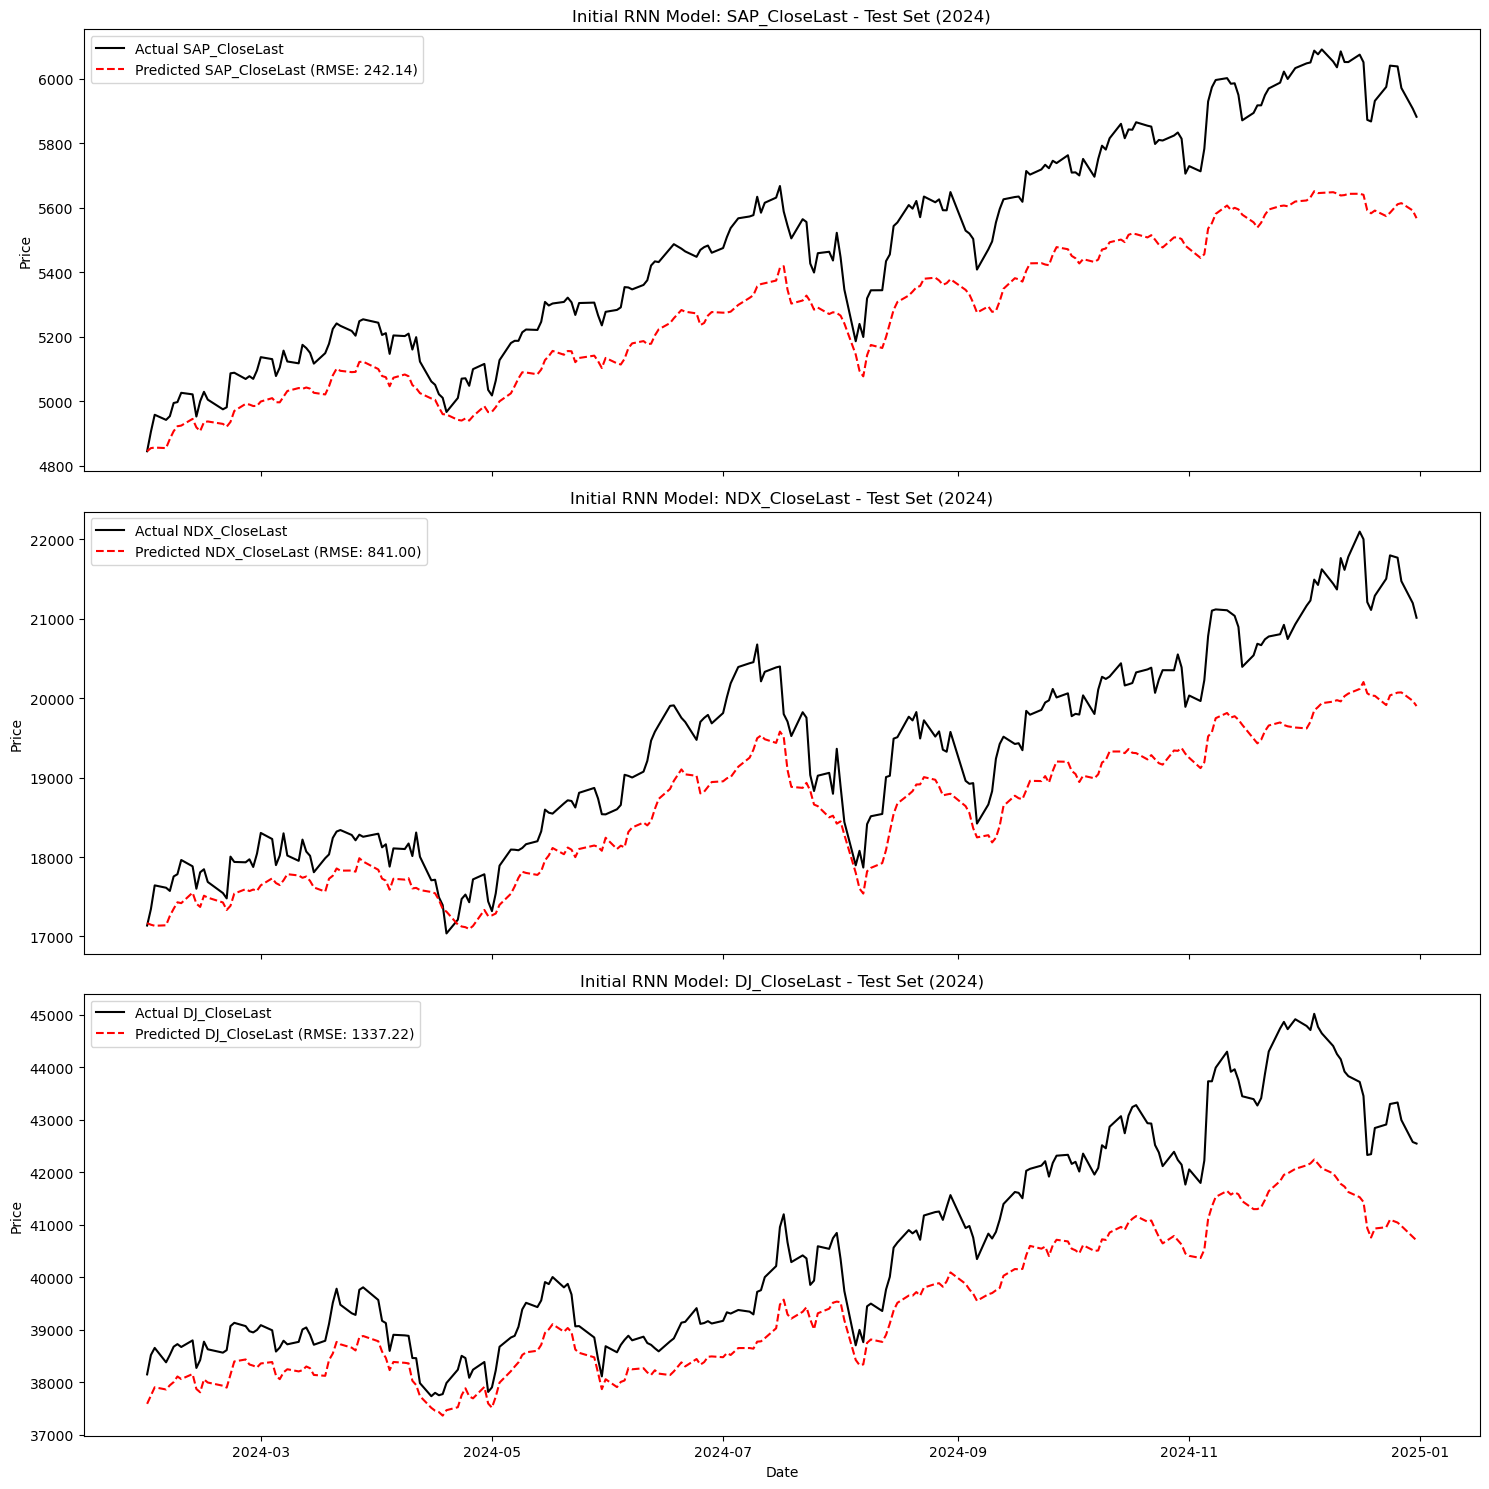

In [4]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_size = X_train.shape[2]
H_initial, L_initial, LR_initial = 64, 2, 0.001

model_initial = StockRNN3(input_size, H_initial, L_initial, output_size=len(target_cols))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_initial.parameters(), lr=LR_initial)

for epoch in range(N_EPOCHS):
    model_initial.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model_initial(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f'Initial RNN Model: Epoch [{epoch+1}/{N_EPOCHS}], Loss: {loss.item():.4f}')

model_initial.eval()
test_predictions_scaled = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model_initial(X_batch)
        test_predictions_scaled.extend(output.numpy())
test_predictions_scaled = np.array(test_predictions_scaled)

dummy_preds_test = np.zeros((len(test_predictions_scaled), len(features_for_scaling)))
dummy_preds_test[:, target_indices_in_scaled_data] = test_predictions_scaled
test_predictions_inversed = scaler.inverse_transform(dummy_preds_test)[:, target_indices_in_scaled_data]

dummy_actuals_test = np.zeros((len(y_test), len(features_for_scaling)))
dummy_actuals_test[:, target_indices_in_scaled_data] = y_test
y_test_inversed = scaler.inverse_transform(dummy_actuals_test)[:, target_indices_in_scaled_data]

test_rmse_per_target = []
for i in range(y_test_inversed.shape[1]):
    rmse = root_mean_squared_error(y_test_inversed[:, i], test_predictions_inversed[:, i])
    test_rmse_per_target.append(rmse)
    print(f'Initial RNN Model - Test RMSE for {target_cols[i]} (2024): {rmse:.2f}')

fig, axs = plt.subplots(len(target_cols), 1, figsize=(15, 5 * len(target_cols)), sharex=True)
if len(target_cols) == 1: axs = [axs] 
for i, ax in enumerate(axs):
    ax.plot(dates_test_seq, y_test_inversed[:, i], label=f'Actual {target_cols[i]}', color='black')
    ax.plot(dates_test_seq, test_predictions_inversed[:, i], label=f'Predicted {target_cols[i]} (RMSE: {test_rmse_per_target[i]:.2f})', color='red', linestyle='--') # Color changed for RNN
    ax.set_title(f'Initial RNN Model: {target_cols[i]} - Test Set (2024)')
    ax.legend()
    ax.set_ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning & Final Validation (2025)

In [5]:
trainval_idx_bool = (dates_processed.year >= 2019) & (dates_processed.year <= 2024)
final_val_idx_bool = dates_processed.year == 2025

scaled_trainval_data = scaler.transform(data_to_scale[trainval_idx_bool])
scaled_final_val_data = scaler.transform(data_to_scale[final_val_idx_bool])

X_trainval, y_trainval = create_sequences_from_combined_array(scaled_trainval_data, SEQ_LEN, target_indices_in_scaled_data)
X_final_val, y_final_val = create_sequences_from_combined_array(scaled_final_val_data, SEQ_LEN, target_indices_in_scaled_data)

dates_trainval_seq = dates_processed[trainval_idx_bool][SEQ_LEN:]
dates_final_val_seq = dates_processed[final_val_idx_bool][SEQ_LEN:]

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32)
X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32)
y_final_val_tensor = torch.tensor(y_final_val, dtype=torch.float32)

trainval_dataset = TensorDataset(X_trainval_tensor, y_trainval_tensor)
trainval_loader = DataLoader(trainval_dataset, batch_size=BATCH_SIZE, shuffle=True)

final_val_dataset = TensorDataset(X_final_val_tensor, y_final_val_tensor)
final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

best_overall_val_rmse = float('inf')
best_params_overall = None
best_model_state_overall = None
results_log = []

input_size_val = X_trainval.shape[2]

for params in all_params:
    H, L, LR = params['hidden_size'], params['num_layers'], params['learning_rate']
    print(f"Tuning RNN with H={H}, L={L}, LR={LR}")
    
    current_model = StockRNN3(input_size_val, H, L, output_size=len(target_cols))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(current_model.parameters(), lr=LR)
    
    for epoch in range(N_EPOCHS):
        current_model.train()
        for X_batch, y_batch in trainval_loader:
            optimizer.zero_grad()
            output = current_model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    current_model.eval()
    current_val_predictions_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader:
            output = current_model(X_batch)
            current_val_predictions_scaled.extend(output.numpy())
    current_val_predictions_scaled = np.array(current_val_predictions_scaled)
    
    dummy_preds_val = np.zeros((len(current_val_predictions_scaled), len(features_for_scaling)))
    dummy_preds_val[:, target_indices_in_scaled_data] = current_val_predictions_scaled
    current_val_predictions_inversed = scaler.inverse_transform(dummy_preds_val)[:, target_indices_in_scaled_data]
    
    dummy_actuals_final_val = np.zeros((len(y_final_val), len(features_for_scaling)))
    dummy_actuals_final_val[:, target_indices_in_scaled_data] = y_final_val
    y_final_val_inversed = scaler.inverse_transform(dummy_actuals_final_val)[:, target_indices_in_scaled_data]
    
    current_rmses = [root_mean_squared_error(y_final_val_inversed[:, i], current_val_predictions_inversed[:, i]) for i in range(y_final_val_inversed.shape[1])]
    avg_rmse = np.mean(current_rmses)
    print(f"RNN Validation RMSEs for H={H}, L={L}, LR={LR}: {current_rmses}, Avg: {avg_rmse:.2f}")
    results_log.append({'params': params, 'avg_rmse': avg_rmse, 'rmses': current_rmses})
    
    if avg_rmse < best_overall_val_rmse:
        best_overall_val_rmse = avg_rmse
        best_params_overall = params
        best_model_state_overall = current_model.state_dict()

print(f"\nBest Overall RNN Validation RMSE: {best_overall_val_rmse:.2f}")
print(f"Best RNN Parameters: {best_params_overall}")

best_model = StockRNN3(input_size_val, 
                       best_params_overall['hidden_size'], 
                       best_params_overall['num_layers'], 
                       output_size=len(target_cols))
best_model.load_state_dict(best_model_state_overall)

Tuning RNN with H=32, L=1, LR=0.001
RNN Validation RMSEs for H=32, L=1, LR=0.001: [109.7735379388525, 425.86845617014325, 455.451518884569], Avg: 330.36
Tuning RNN with H=32, L=1, LR=0.0005
RNN Validation RMSEs for H=32, L=1, LR=0.0005: [89.30766774625589, 444.2989932102704, 681.613785858817], Avg: 405.07
Tuning RNN with H=32, L=2, LR=0.001
RNN Validation RMSEs for H=32, L=2, LR=0.001: [80.32756299901924, 412.9236504948668, 520.1191159017833], Avg: 337.79
Tuning RNN with H=32, L=2, LR=0.0005
RNN Validation RMSEs for H=32, L=2, LR=0.0005: [89.45376855901212, 500.1115967302854, 653.8284368678002], Avg: 414.46
Tuning RNN with H=64, L=1, LR=0.001
RNN Validation RMSEs for H=64, L=1, LR=0.001: [69.45506204695867, 361.29781982209346, 417.81586353328856], Avg: 282.86
Tuning RNN with H=64, L=1, LR=0.0005
RNN Validation RMSEs for H=64, L=1, LR=0.0005: [91.52678493671024, 425.59081121995837, 589.0945852597721], Avg: 368.74
Tuning RNN with H=64, L=2, LR=0.001
RNN Validation RMSEs for H=64, L=2, LR

<All keys matched successfully>

Best RNN Model - Final Validation RMSE for SAP_CloseLast (2025): 62.08
Best RNN Model - Final Validation RMSE for NDX_CloseLast (2025): 371.10
Best RNN Model - Final Validation RMSE for DJ_CloseLast (2025): 261.50


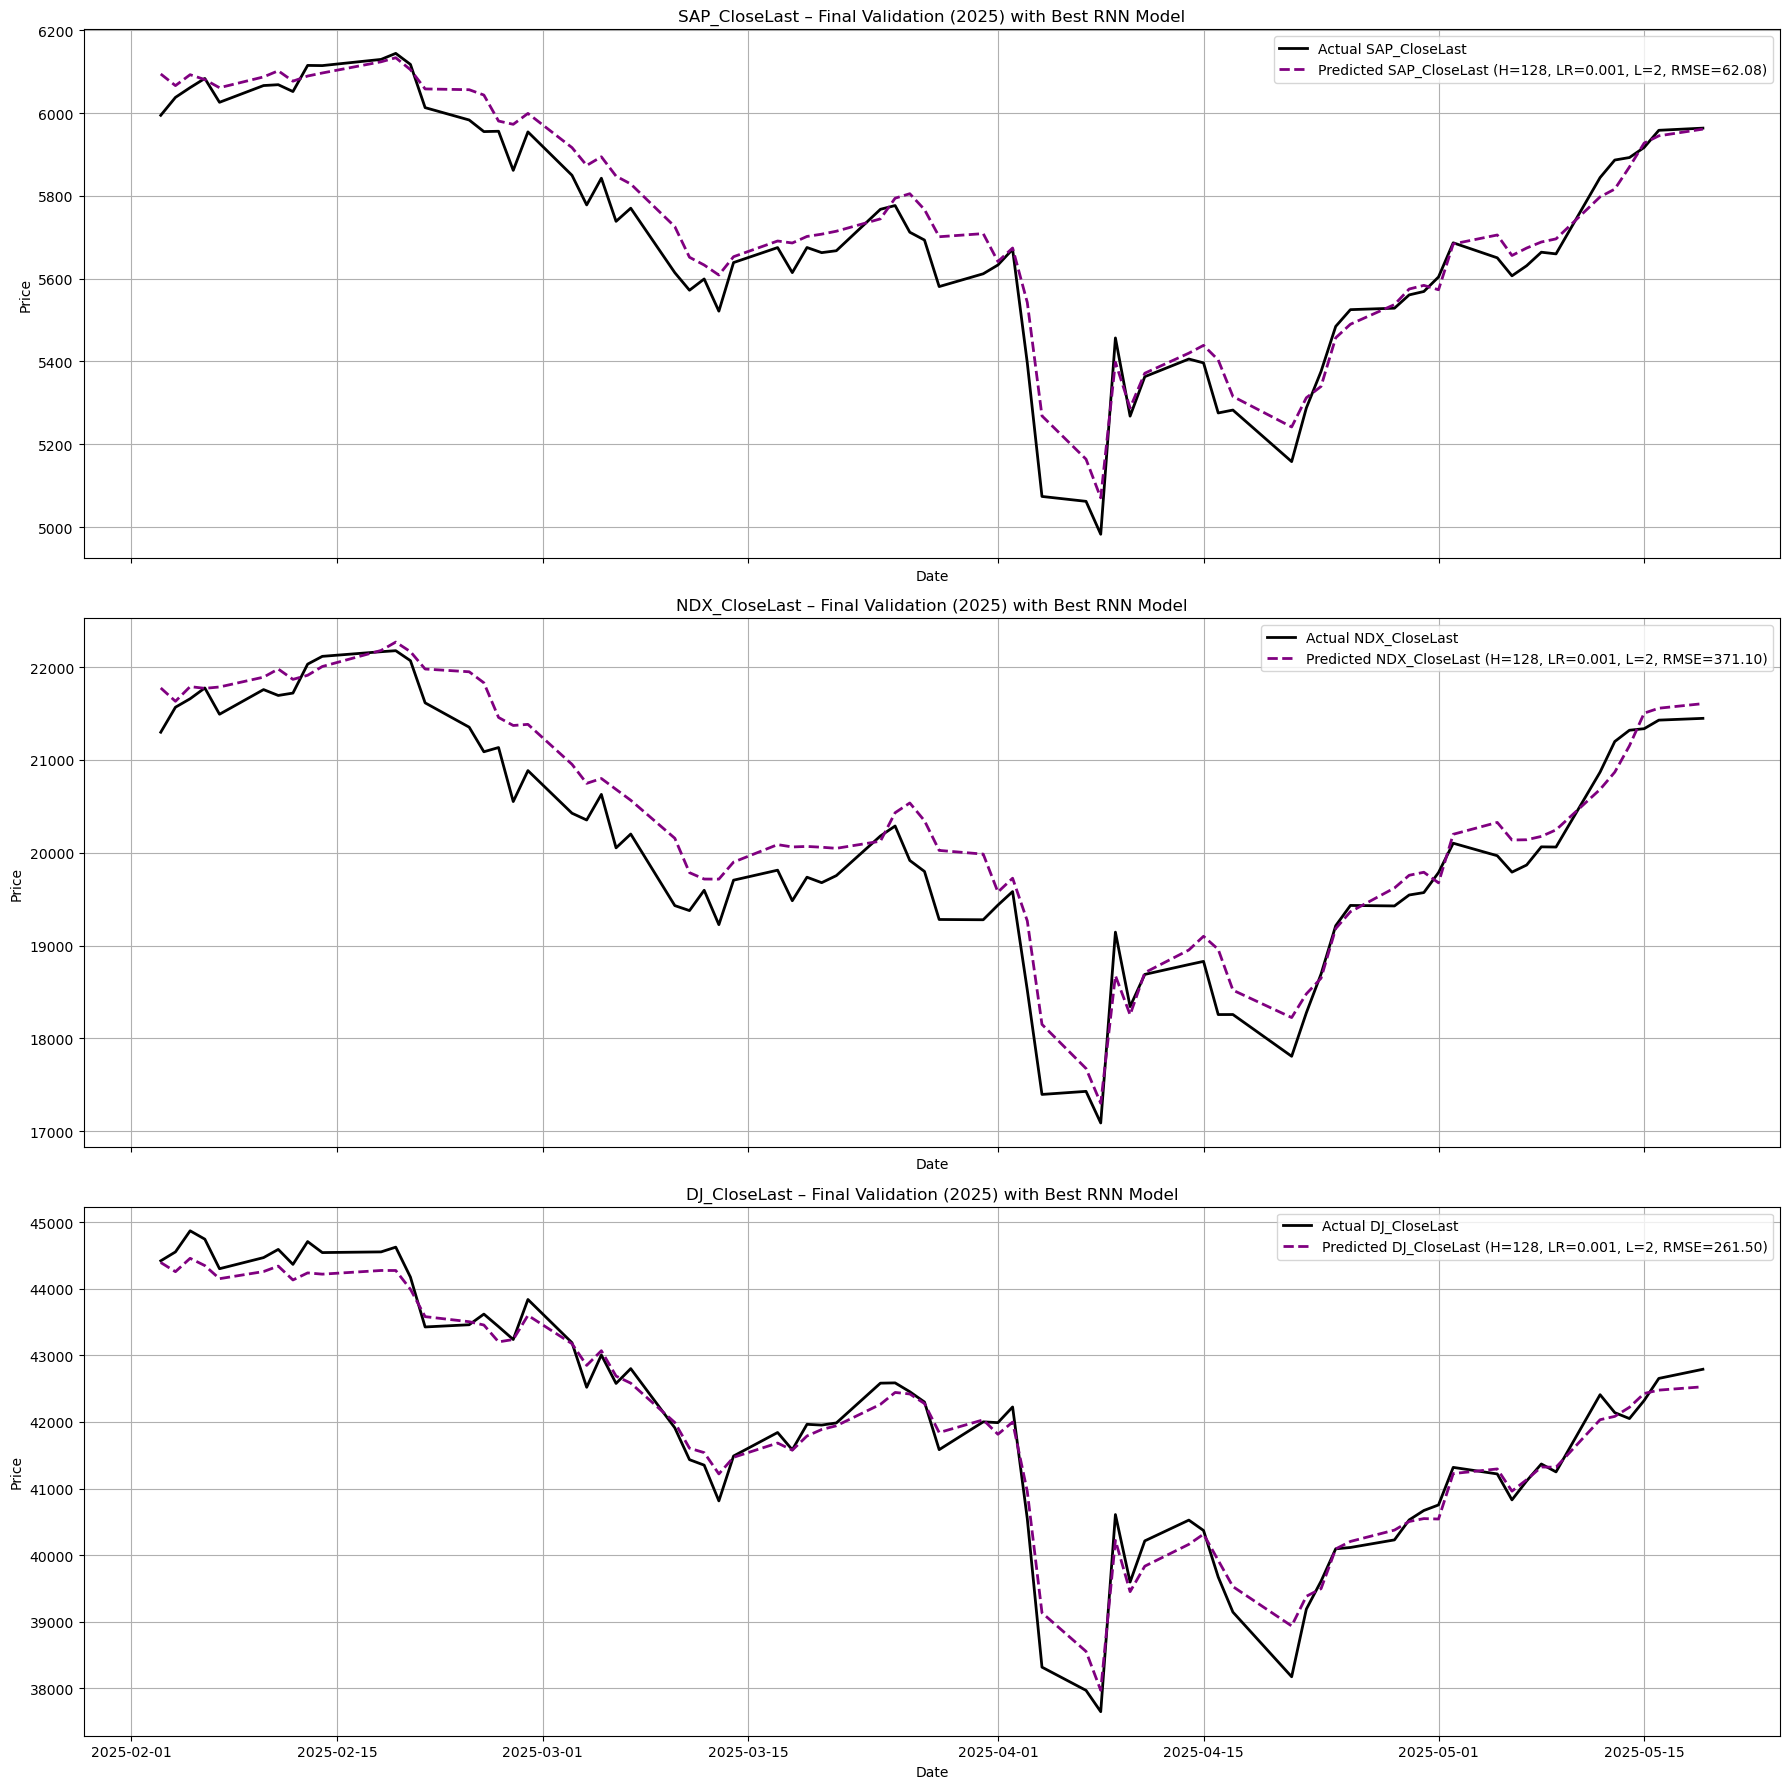

In [7]:
best_model.eval()
final_predictions_scaled = []
with torch.no_grad():
    for X_batch, y_batch in final_val_loader:
        output = best_model(X_batch)
        final_predictions_scaled.extend(output.numpy())
final_predictions_scaled = np.array(final_predictions_scaled)

dummy_final_preds = np.zeros((len(final_predictions_scaled), len(features_for_scaling)))
dummy_final_preds[:, target_indices_in_scaled_data] = final_predictions_scaled
final_predictions_inversed = scaler.inverse_transform(dummy_final_preds)[:, target_indices_in_scaled_data]

dummy_actuals_final_val_plot = np.zeros((len(y_final_val), len(features_for_scaling)))
dummy_actuals_final_val_plot[:, target_indices_in_scaled_data] = y_final_val
y_final_val_inversed_for_plot = scaler.inverse_transform(dummy_actuals_final_val_plot)[:, target_indices_in_scaled_data]

final_val_rmses = []
for i in range(y_final_val_inversed_for_plot.shape[1]):
    rmse = root_mean_squared_error(y_final_val_inversed_for_plot[:, i], final_predictions_inversed[:, i])
    final_val_rmses.append(rmse)
    print(f'Best RNN Model - Final Validation RMSE for {target_cols[i]} (2025): {rmse:.2f}')

H_best = best_params_overall['hidden_size']
LR_best = best_params_overall['learning_rate']
L_best = best_params_overall['num_layers']

fig, axs = plt.subplots(len(target_cols), 1, figsize=(18, 6 * len(target_cols)), sharex=True)
if len(target_cols) == 1: axs = [axs]

for i, ax in enumerate(axs):
    feature_name = target_cols[i]
    rmse_val = final_val_rmses[i]
    legend_label = f"Predicted {feature_name} (H={H_best}, LR={LR_best}, L={L_best}, RMSE={rmse_val:.2f})"
    
    ax.plot(dates_final_val_seq, y_final_val_inversed_for_plot[:, i],
            label=f"Actual {feature_name}", color="black", linewidth=2)
    ax.plot(dates_final_val_seq, final_predictions_inversed[:, i],
            label=legend_label, color="purple", linewidth=2, linestyle='--') # Changed color for RNN
    ax.set_title(f"{feature_name} – Final Validation (2025) with Best RNN Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()